In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Load Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DT-Wage.csv')

In [4]:
df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [5]:
df.shape

(3000, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 257.9+ KB


In [7]:
df.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [8]:
df.isnull().sum()

,0
year,0
age,0
maritl,0
race,0
education,0
region,0
jobclass,0
health,0
health_ins,0
logwage,0


Separate categorical and numerical columns

In [9]:
un = df['maritl'].unique()
print(un)

['1. Never Married' '2. Married' '4. Divorced' '3. Widowed' '5. Separated']


In [10]:
un = df['race'].unique()
print(un)

['1. White' '3. Asian' '4. Other' '2. Black']


In [11]:
un = df['education'].unique()
print(un)

['1. < HS Grad' '4. College Grad' '3. Some College' '2. HS Grad'
 '5. Advanced Degree']


In [12]:
un = df['region'].unique()
print(un)

['2. Middle Atlantic']


In [13]:
un = df['jobclass'].unique()
print(un)

['1. Industrial' '2. Information']


In [14]:
un = df['health'].unique()
print(un)

['1. <=Good' '2. >=Very Good']


In [15]:
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(exclude=['object']).columns


One-hot encode for categorical features

In [16]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical))
encoded_df.index = df.index


In [17]:
df = df.drop(categorical, axis=1)
df = pd.concat([df, encoded_df], axis=1)


In [18]:
X = df.drop(columns=['wage'])
y = df['wage']

In [19]:
X.head()

,year,age,logwage,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_2. Black,race_3. Asian,race_4. Other,education_2. HS Grad,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,jobclass_2. Information,health_2. >=Very Good,health_ins_2. No
0,2006,18,4.318063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2004,24,4.255273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,2003,45,4.875061,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2003,43,5.041393,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,2005,50,4.318063,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
X.shape

(3000, 17)

In [21]:
corr = df.corr()

target = corr['wage'].sort_values(ascending=False)

print("Correlation of each feature with the target variable (wage):")
print(target)

Correlation of each feature with the target variable (wage):
wage                            1.000000
logwage                         0.950683
education_5. Advanced Degree    0.382369
maritl_2. Married               0.256713
jobclass_2. Information         0.206897
age                             0.195637
education_4. College Grad       0.165898
health_2. >=Very Good           0.152337
year                            0.065544
race_3. Asian                   0.053504
maritl_3. Widowed              -0.023278
maritl_5. Separated            -0.034353
education_3. Some College      -0.049767
maritl_4. Divorced             -0.055318
race_4. Other                  -0.058202
race_2. Black                  -0.079663
education_2. HS Grad           -0.263972
health_ins_2. No               -0.308310
Name: wage, dtype: float64


Standardize features

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split data: 70% train, 15% validate, 15% test

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [24]:
X_train.shape

(2100, 17)

In [25]:
X_val.shape

(450, 17)

In [26]:
X_test.shape

(450, 17)

In [27]:
X_train

array([[ 1.09041746, -1.24905242, -0.88566318, ..., -0.97108454,
         0.63289827, -0.66349863],
       [-1.37770717, -1.50900691, -0.72780625, ..., -0.97108454,
         0.63289827,  1.50716211],
       [-0.88408224, -0.90244644, -0.00196921, ...,  1.02977646,
         0.63289827, -0.66349863],
       ...,
       [ 0.59679254, -1.24905242, -0.50266379, ...,  1.02977646,
         0.63289827,  1.50716211],
       [-0.39045732,  0.74393197,  0.12813678, ...,  1.02977646,
         0.63289827, -0.66349863],
       [ 1.58404239,  1.17718945, -0.7782159 , ...,  1.02977646,
        -1.58003275,  1.50716211]])

hyperparameter tuning

In [28]:
param_grid = {
    'max_depth': [3, 5, 7, 10,12, None],
    'min_samples_split': [2, 5, 10,12],
    'min_samples_leaf': [1, 2, 5,7],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
}


DecisionTreeRegressor

In [29]:
model = DecisionTreeRegressor(random_state=42)

Initialize GridSearchCV

In [30]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')


Fit Data

In [31]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [3, 5, 7, 10, 12, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5, 7],
                         'min_samples_split': [2, 5, 10, 12]},
             scoring='neg_mean_squared_error', verbose=2)

In [32]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [33]:
best_model = grid_search.best_estimator_

Predict and Evaluate the performance

In [34]:
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Validation):", mse_val)
print("Mean Squared Error (Test):", mse_test)
print("R² (Train): {:.2f}".format(r2_train))
print("R² (Validation): {:.2f}".format(r2_val))
print("R² (Test): {:.2f}".format(r2_test))


Mean Squared Error (Train): 1.410418748340405e-09
Mean Squared Error (Validation): 0.12851525998284974
Mean Squared Error (Test): 0.6726064455351682
R² (Train): 1.00
R² (Validation): 1.00
R² (Test): 1.00


## Using XGBOOSTER

In [35]:
from xgboost import XGBRegressor

In [36]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

XGBoost hyperparameter tuning

In [37]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}


In [38]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [39]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [40]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


performance of xgboost

In [41]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Validation):", mse_val)
print("Mean Squared Error (Test):", mse_test)
print("R² (Train): {:.2f}".format(r2_train))
print("R² (Validation): {:.2f}".format(r2_val))
print("R² (Test): {:.2f}".format(r2_test))


Mean Squared Error (Train): 0.3688379649319509
Mean Squared Error (Validation): 0.3145895149944105
Mean Squared Error (Test): 2.1066486879107766
R² (Train): 1.00
R² (Validation): 1.00
R² (Test): 1.00


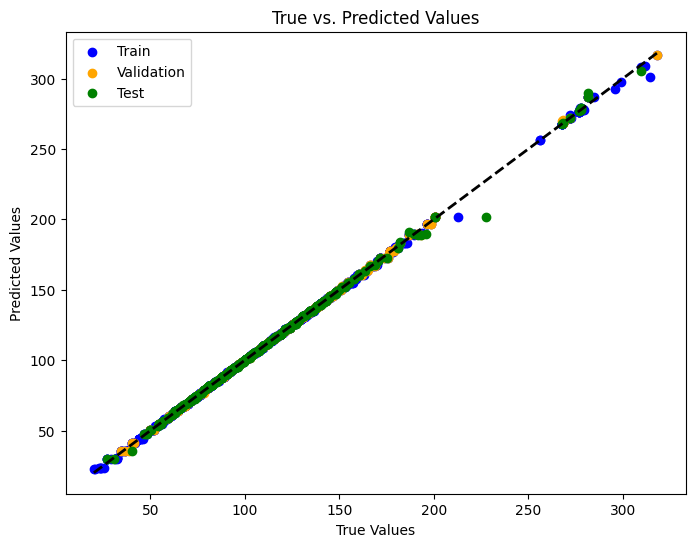

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color="blue", label="Train")
plt.scatter(y_val, y_val_pred, color="orange", label="Validation")
plt.scatter(y_test, y_test_pred, color="green", label="Test")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.legend()
plt.show()

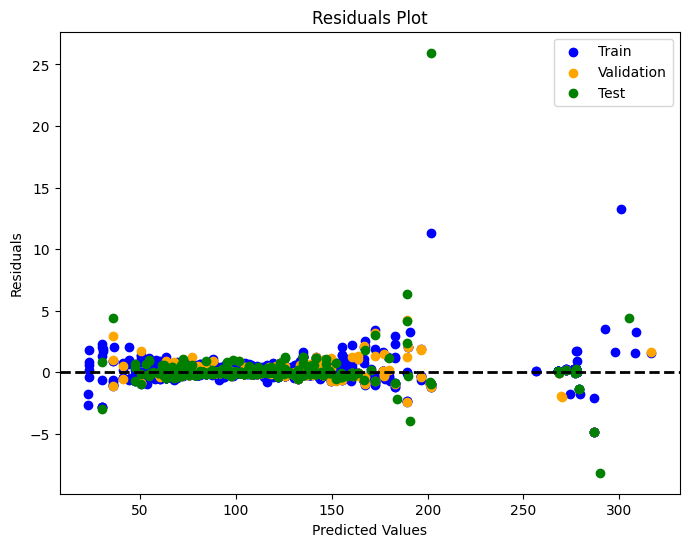

In [43]:
train_residuals = y_train - y_train_pred
val_residuals = y_val - y_val_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, color="blue", label="Train")
plt.scatter(y_val_pred, val_residuals, color="orange", label="Validation")
plt.scatter(y_test_pred, test_residuals, color="green", label="Test")
plt.axhline(0, color="black", linestyle="--", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.show()
